In [1]:
import utils as ul
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from numba import jit
cdir = ""
run = 129
pltdir = "Run" + str(run) + "/"

In [2]:
df1 = pd.read_csv(cdir+"Run{}_coinc.dat".format(run), sep="\t", header=None, low_memory=False)
df1.columns = ["A", "B", "TimeL", "ChargeL", "ChannelIDL", "C", "D", "TimeR", "ChargeR", "ChannelIDR"]
df1["Left"] = df1.ChannelIDR % 128
df1["Right"] = df1.ChannelIDL % 128
df1.ChannelIDR = df1.Right
df1.ChannelIDL = df1.Left
# a = [ul.toGeo(i) for i in df1.Left]
# b = [ul.toGeo(i) for i in df1.Right]
# df1["GeoChannelIDL"] = a
# df1["GeoChannelIDR"] = b

#making the almighty dataframe which will store everything we need, praise be
# DATA = pd.DataFrame(columns=["ChannelIDL", "ChannelIDR", "PP_Count", "E_ResL", "E_ResR", "QINTL", "QINTR", "CTR", "E_Cut", "PP_Cut"])

pairs = df1.groupby(["ChannelIDL","ChannelIDR"]).size().reset_index(name="Counts",drop=False).sort_values(by='Counts', ascending=False).reset_index()
print(pairs)

       index  ChannelIDL  ChannelIDR  Counts
0      13968         109          16    3687
1      15110         118           7    3623
2      13333         104          21    3566
3      14978         117           3    3557
4      14733         115          14    3539
...      ...         ...         ...     ...
16378   3219          25          19       2
16379   4003          31          35       2
16380  13770         107          74       2
16381   4158          32          62       1
16382    415           3          31       1

[16383 rows x 4 columns]


In [3]:
#obviously there has to be 100 total events to have 100 PP events
num_photons = 100
valid_channels = pairs[pairs["Counts"] >= num_photons].reset_index()
print(valid_channels)

      level_0  index  ChannelIDL  ChannelIDR  Counts
0           0  13968         109          16    3687
1           1  15110         118           7    3623
2           2  13333         104          21    3566
3           3  14978         117           3    3557
4           4  14733         115          14    3539
...       ...    ...         ...         ...     ...
2691     2691   7106          55          66     100
2692     2692    746           5         106     100
2693     2693  10238          79         126     100
2694     2694   5838          45          78     100
2695     2695   4219          32         123     100

[2696 rows x 5 columns]


  0%|                                                                                 | 1/1000 [00:00<04:14,  3.92it/s]


UnboundLocalError: local variable 'data' referenced before assignment

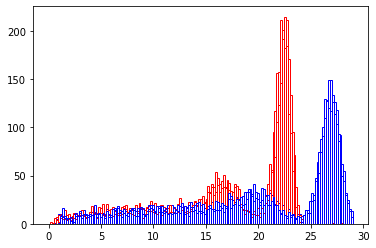

In [60]:
count = valid_channels.ChannelIDL.count()
print(count)
maxN = np.Infinity
if maxN > count:
    maxN = count

maxfilled = 4000*maxN
data0 = np.zeros(shape=(4,maxfilled))
k=0


for j in tqdm(range(maxN)):
    test = df1[df1["ChannelIDL"] == valid_channels.ChannelIDL[j]]
    test = test[test["ChannelIDR"] == valid_channels.ChannelIDR[j]].reset_index()
    RChannel = valid_channels.ChannelIDR[j]
    LChannel = valid_channels.ChannelIDL[j]  
    RGeo = ul.toGeo(RChannel)
    LGeo = ul.toGeo(LChannel)
    
    values,bins,presenters = plt.hist(test.ChargeR, bins = np.linspace(0,29,160), ec='r',label='PCB 5', fill=False)
    values1,bins1,presenters1 = plt.hist(test.ChargeL, bins = np.linspace(0,29,160), ec='b',label='PCB 6', fill=False)
    values = values.tolist()
    values1 = values1.tolist()

    #Both histograms have the same binning, so it doesn't matter how we make our bin centers
    bin_centers = [(bins[q] + bins[q+1])/2 for q in range(0,len(bins)-1)]
    #find the peak within 3 bins starting from the RHS of the graph
    for i in range(1, len(values)-4):
        if values[-1*i] > values[-1*(i+1)] and values[-1*i] > values[-1*(i+2)] and values[-1*i] > values[-1*(i+3)] and values[-1*(i+1)] != 0:
            peak = values.index(values[-1*i])
            break
    for i in range(1, len(values1)-4):
        if values1[-1*i] > values1[-1*(i+1)] and values1[-1*i] > values1[-1*(i+2)] and values1[-1*i] > values1[-1*(i+3)]and values1[-1*(i+1)] != 0:
            peak1 = values1.index(values1[-1*i])
            break


    #Taking the x and y data from 3 bins on either side of the peak
    fit_x = bin_centers[peak-6:peak+7]
    fit_x1 = bin_centers[peak1-6:peak1+7]
    fit_y = values[peak-6:peak+7]
    fit_y1 = values1[peak1-6:peak1+7]

    x_p = [0,1,1]
    x1_p = [0,1,1]
    #fitting said data and recording photpeak energy cuts
    if len(fit_y) != 0 and len(fit_x) != 0:
        try:
            x_p, x_co = curve_fit(ul.gauss, fit_x, fit_y, p0=[100, fit_x[3], 2])
        except RuntimeError:
            print("Error - curve_fit failed on Right PCB Failed")

    if len(fit_x1) != 0 and len(fit_y1) != 0:
        try:
            x1_p, x1_co = curve_fit(ul.gauss, fit_x1, fit_y1,p0=[200,fit_x1[3],2])
        except RuntimeError:
            print("Error - curve_fit failed on Left PCB Failed")

    E_ResR = abs(100*(2.3548*abs(x_p[2]))/x_p[1])
    E_ResL = abs(100*(2.3548*abs(x1_p[2]))/x1_p[1])

    # plotting every energy spectrum
    # x_f = np.linspace(0,50,500)
    # plt.plot(x_f, ul.gauss(x_f,*x_p), color='k')
    # plt.plot(x_f, ul.gauss(x_f,*x1_p), color='k')
    # t_y = ul.generateTextY(10,400)
    # t_x = 1
    # LGeo = ul.toGeo(LChannel)
    # RGeo = ul.toGeo(RChannel)
    # plt.text(t_x,t_y[0], "PCB 5:")
    # plt.text(t_x,t_y[1], "mean: "+format(x_p[1], "5.2f"))
    # plt.text(t_x,t_y[2], "std: "+format(abs(x_p[2]), "5.2f"))
    # plt.text(t_x,t_y[3], "count: "+format(test.ChargeR.count(), "5"))
    # plt.text(t_x,t_y[4], "ERes: "+format(abs(100*(2.3548*abs(x_p[2]))/x_p[1]), "5.2f")+"%")
    # plt.text(t_x,t_y[5], "PCB 6:")
    # plt.text(t_x,t_y[6], "mean: "+format(x1_p[1], "5.2f"))
    # plt.text(t_x,t_y[7], "std: "+format(abs(x1_p[2]), "5.2f"))
    # plt.text(t_x,t_y[8], "count: "+format(test.ChargeL.count(), "5"))
    # plt.text(t_x,t_y[9], "ERes: "+format(abs(100*(2.3548*abs(x1_p[2]))/x1_p[1]), "5.2f")+"%")
    # plt.ylim(0,400)
    # plt.title("Energy Spectrum Pair {}-{}".format(LGeo, RGeo))
    # plt.legend()
    # plt.savefig(pltdir+"Energy Spectrum Pair {}-{}".format(LGeo, RGeo))
    # # plt.show()
    # plt.clf()

   # cutting on the photopeak
    R_Cut = x_p[1] - 2.5*x_p[2]
    L_Cut = x1_p[1] - 2.5*x1_p[2]
    if (x_p[1] > 10.5) and (x1_p[1] > 10.5):
        test = test[test["ChargeR"] >= R_Cut]
        test = test[test["ChargeL"] >= L_Cut]
        #records Time difference
        test["Time_diff"] = 10**-3 * (test["TimeL"] - test["TimeR"])
        TRes5_UN = test.Time_diff.tolist()
        #fitting each CTR graph if there is enough data
        if (len(TRes5_UN) < 100):
            #didn't pass the photopeak cut
            pass
        else:
            tl = test["TimeL"].to_numpy()
            tr = test["TimeR"].to_numpy()
            # print(test["TimeL"], LGeo, test["TimeR"], RGeo)
            for i in range(len(test["TimeL"])):
                data0[:,k] = [tl[i], LGeo, tr[i], RGeo]
                k+=1

            
            
            # TRes5_UN = pd.Series(TRes5_UN)
            # low = -2
            # high = low * -1
            # num_bins = 100
            # bins = np.linspace(low,high,num_bins)
            # x = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),num_bins-1)
            # y1 = TRes5_UN.value_counts(bins=bins,sort=False).tolist()
            # peak = y1.index(max(y1))
            # bin_centers = [(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)]
            # fit_x = bin_centers[peak-12:peak+13]
            # fit_y = y1[peak-12:peak+13]
            # try:
            #     x1_p, x1_co = curve_fit(ul.gauss,fit_x,fit_y, p0=[75,TRes5_UN.mean(),TRes5_UN.std()])
            # except RuntimeError:
            #     print("Error - curve_fit failed")

            # DATA = DATA.append({"ChannelIDL":LChannel, "ChannelIDR":RChannel, "PP_Count":len(TRes5_UN), "E_ResL":E_ResL, "E_ResR":E_ResR,"QINTL":INTL, "QINTR":INTR,"CTR":2.3548* x1_p[2], "E_Cut":1, "PP_Cut":1},ignore_index=True)
            # print(j)
            # return [LChannel,RChannel]
            #if you want to see every spectrum
            
            # fig1 = plt.figure()
            # ax1 = fig1.add_subplot(111,xlim=(-2,2), ylim=(0,100),xlabel="Time in ns",ylabel="Counts",title="CTR: Channel Pair {}-{}".format(LGeo,RGeo))
            # x_p = np.linspace(low+((high-low)/(2*num_bins)),high-((high-low)/(2*num_bins)),400)
            # T_x = -1.9
            # T_y = ul.generateTextY(9,100)
            # ax1.hist(TRes5_UN, bins=bins,color='b')
            # ax1.plot(x_p,gauss(x_p,x1_p[0],x1_p[1],x1_p[2]), color='k')
            # ax1.text(T_x,T_y[0],"Data Stats:")
            # ax1.text(T_x,T_y[1],"mean: "+format(TRes5_UN.mean(),"5.2f"))
            # ax1.text(T_x,T_y[2],"std: "+format(TRes5_UN.std(),"7.4f"))
            # ax1.text(T_x,T_y[3],"count: "+str(len(TRes5_UN)))
            # ax1.text(T_x,T_y[4],"Fit Paramters:")
            # ax1.text(T_x,T_y[5],"mu: "+format(x1_p[1],"5.2f"))
            # ax1.text(T_x,T_y[6],"sigma: "+format(x1_p[2],"7.4f"))
            # ax1.text(T_x,T_y[7],"A: "+format(x1_p[0],"5.2f"))
            # ax1.text(T_x,T_y[8],"FWHM: "+format(2.3548* x1_p[2],"7.4f"))
            # plt.savefig(pltdir+"CTR: Channel Pair {}-{}".format(LGeo,RGeo)+".png")
            # plt.clf()
            # plt.close()
    else:
        pass
        #didn't pass the Energy cut
print(k)
data = data0[:,0:k]

  0%|                                                                                 | 1/2696 [00:00<06:10,  7.26it/s]

2696


 19%|██████████████▊                                                                | 507/2696 [02:32<14:33,  2.51it/s]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 23%|██████████████████▏                                                            | 619/2696 [03:23<26:14,  1.32it/s]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 23%|██████████████████▍                                                            | 628/2696 [03:27<16:30,  2.09it/s]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimat

Error - curve_fit failed on Right PCB Failed


 35%|███████████████████████████▍                                                   | 937/2696 [06:21<18:40,  1.57it/s]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 36%|████████████████████████████▏                                                  | 964/2696 [06:39<18:57,  1.52it/s]

Error - curve_fit failed on Left PCB Failed


 37%|█████████████████████████████▏                                                | 1009/2696 [07:12<19:30,  1.44it/s]

Error - curve_fit failed on Left PCB Failed


 39%|██████████████████████████████▋                                               | 1062/2696 [07:49<19:21,  1.41it/s]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 40%|███████████████████████████████                                               | 1074/2696 [07:57<19:21,  1.40it/s]

Error - curve_fit failed on Right PCB Failed


 40%|███████████████████████████████▏                                              | 1079/2696 [08:01<19:24,  1.39it/s]

Error - curve_fit failed on Left PCB Failed


 40%|███████████████████████████████▍                                              | 1086/2696 [08:06<19:24,  1.38it/s]

Error - curve_fit failed on Left PCB Failed


 58%|████████████████████████████████████████████▊                                 | 1551/2696 [14:50<18:56,  1.01it/s]

Error - curve_fit failed on Left PCB Failed


 58%|█████████████████████████████████████████████                                 | 1557/2696 [14:56<18:56,  1.00it/s]

Error - curve_fit failed on Left PCB Failed


 61%|███████████████████████████████████████████████▍                              | 1639/2696 [16:24<18:20,  1.04s/it]

Error - curve_fit failed on Left PCB Failed


 61%|███████████████████████████████████████████████▊                              | 1654/2696 [16:40<18:09,  1.05s/it]

Error - curve_fit failed on Left PCB Failed


 62%|████████████████████████████████████████████████▍                             | 1675/2696 [17:02<18:01,  1.06s/it]

Error - curve_fit failed on Left PCB Failed


 62%|████████████████████████████████████████████████▌                             | 1680/2696 [17:07<17:53,  1.06s/it]

Error - curve_fit failed on Right PCB Failed


 62%|████████████████████████████████████████████████▋                             | 1681/2696 [17:08<17:54,  1.06s/it]

Error - curve_fit failed on Left PCB Failed


 63%|█████████████████████████████████████████████████▌                            | 1711/2696 [17:41<17:48,  1.09s/it]

Error - curve_fit failed on Left PCB Failed


 64%|██████████████████████████████████████████████████                            | 1731/2696 [18:02<17:39,  1.10s/it]

Error - curve_fit failed on Left PCB Failed


 65%|██████████████████████████████████████████████████▋                           | 1750/2696 [18:23<17:23,  1.10s/it]

Error - curve_fit failed on Left PCB Failed


 65%|██████████████████████████████████████████████████▉                           | 1760/2696 [18:34<17:22,  1.11s/it]

Error - curve_fit failed on Left PCB Failed


 65%|██████████████████████████████████████████████████▉                           | 1761/2696 [18:35<17:21,  1.11s/it]

Error - curve_fit failed on Left PCB Failed


 65%|███████████████████████████████████████████████████                           | 1764/2696 [18:39<17:17,  1.11s/it]

Error - curve_fit failed on Right PCB Failed


 66%|███████████████████████████████████████████████████                           | 1766/2696 [18:41<17:16,  1.11s/it]

Error - curve_fit failed on Left PCB Failed


 66%|███████████████████████████████████████████████████▋                          | 1785/2696 [19:02<17:00,  1.12s/it]

Error - curve_fit failed on Left PCB Failed


 67%|███████████████████████████████████████████████████▉                          | 1795/2696 [19:13<16:51,  1.12s/it]

Error - curve_fit failed on Right PCB Failed


 67%|███████████████████████████████████████████████████▉                          | 1797/2696 [19:16<16:55,  1.13s/it]

Error - curve_fit failed on Left PCB Failed


 67%|████████████████████████████████████████████████████▏                         | 1804/2696 [19:24<16:49,  1.13s/it]

Error - curve_fit failed on Left PCB Failed


 68%|████████████████████████████████████████████████████▊                         | 1825/2696 [19:48<16:36,  1.14s/it]

Error - curve_fit failed on Left PCB Failed


 68%|████████████████████████████████████████████████████▊                         | 1826/2696 [19:49<16:33,  1.14s/it]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 68%|████████████████████████████████████████████████████▉                         | 1829/2696 [19:52<16:33,  1.15s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 68%|█████████████████████████████████████████████████████                         | 1835/2696 [19:59<16:28,  1.15s/it]

Error - curve_fit failed on Left PCB Failed


 68%|█████████████████████████████████████████████████████▏                        | 1839/2696 [20:04<16:28,  1.15s/it]

Error - curve_fit failed on Left PCB Failed


 68%|█████████████████████████████████████████████████████▍                        | 1845/2696 [20:11<16:23,  1.16s/it]

Error - curve_fit failed on Right PCB Failed


 69%|█████████████████████████████████████████████████████▉                        | 1864/2696 [20:33<16:11,  1.17s/it]

Error - curve_fit failed on Right PCB Failed


 69%|██████████████████████████████████████████████████████▏                       | 1871/2696 [20:41<16:02,  1.17s/it]

Error - curve_fit failed on Left PCB Failed


 70%|██████████████████████████████████████████████████████▍                       | 1880/2696 [20:51<16:05,  1.18s/it]

Error - curve_fit failed on Left PCB Failed


 70%|██████████████████████████████████████████████████████▌                       | 1888/2696 [21:01<15:55,  1.18s/it]

Error - curve_fit failed on Right PCB Failed


 70%|██████████████████████████████████████████████████████▋                       | 1891/2696 [21:04<15:51,  1.18s/it]

Error - curve_fit failed on Left PCB Failed


 70%|██████████████████████████████████████████████████████▉                       | 1898/2696 [21:13<15:47,  1.19s/it]

Error - curve_fit failed on Right PCB Failed


 71%|███████████████████████████████████████████████████████▏                      | 1907/2696 [21:24<15:45,  1.20s/it]

Error - curve_fit failed on Right PCB Failed


 71%|███████████████████████████████████████████████████████▎                      | 1911/2696 [21:28<15:41,  1.20s/it]

Error - curve_fit failed on Right PCB Failed


 71%|███████████████████████████████████████████████████████▍                      | 1918/2696 [21:37<15:36,  1.20s/it]

Error - curve_fit failed on Left PCB Failed


 71%|███████████████████████████████████████████████████████▌                      | 1920/2696 [21:39<15:35,  1.21s/it]

Error - curve_fit failed on Right PCB Failed


 72%|████████████████████████████████████████████████████████▎                     | 1947/2696 [22:12<15:15,  1.22s/it]

Error - curve_fit failed on Left PCB Failed


 72%|████████████████████████████████████████████████████████▍                     | 1951/2696 [22:17<15:13,  1.23s/it]

Error - curve_fit failed on Right PCB Failed


 73%|████████████████████████████████████████████████████████▉                     | 1970/2696 [22:40<14:54,  1.23s/it]

Error - curve_fit failed on Right PCB Failed


 73%|█████████████████████████████████████████████████████████                     | 1971/2696 [22:41<14:54,  1.23s/it]

Error - curve_fit failed on Left PCB Failed


 73%|█████████████████████████████████████████████████████████                     | 1972/2696 [22:43<14:53,  1.23s/it]

Error - curve_fit failed on Right PCB Failed


 73%|█████████████████████████████████████████████████████████▏                    | 1976/2696 [22:47<14:49,  1.24s/it]

Error - curve_fit failed on Left PCB Failed


 73%|█████████████████████████████████████████████████████████▏                    | 1978/2696 [22:50<14:46,  1.24s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 74%|█████████████████████████████████████████████████████████▉                    | 2004/2696 [23:28<14:37,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 75%|██████████████████████████████████████████████████████████▏                   | 2010/2696 [23:36<14:18,  1.25s/it]

Error - curve_fit failed on Right PCB Failed


 75%|██████████████████████████████████████████████████████████▋                   | 2027/2696 [23:57<14:00,  1.26s/it]

Error - curve_fit failed on Left PCB Failed


 75%|██████████████████████████████████████████████████████████▉                   | 2035/2696 [24:07<13:51,  1.26s/it]

Error - curve_fit failed on Right PCB Failed


 76%|██████████████████████████████████████████████████████████▉                   | 2038/2696 [24:11<13:52,  1.27s/it]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 76%|██████████████████████████████████████████████████████████▉                   | 2039/2696 [24:12<13:53,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 76%|███████████████████████████████████████████████████████████                   | 2040/2696 [24:13<13:51,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 76%|███████████████████████████████████████████████████████████▏                  | 2045/2696 [24:20<13:45,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 76%|███████████████████████████████████████████████████████████▎                  | 2051/2696 [24:27<13:41,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 76%|███████████████████████████████████████████████████████████▎                  | 2052/2696 [24:29<13:40,  1.27s/it]

Error - curve_fit failed on Left PCB Failed


 76%|███████████████████████████████████████████████████████████▌                  | 2060/2696 [24:39<13:29,  1.27s/it]

Error - curve_fit failed on Right PCB Failed


 77%|███████████████████████████████████████████████████████████▊                  | 2066/2696 [24:46<13:24,  1.28s/it]

Error - curve_fit failed on Right PCB Failed


 77%|███████████████████████████████████████████████████████████▉                  | 2072/2696 [24:54<13:20,  1.28s/it]

Error - curve_fit failed on Left PCB Failed


 78%|████████████████████████████████████████████████████████████▋                 | 2098/2696 [25:28<12:54,  1.30s/it]

Error - curve_fit failed on Right PCB Failed


 78%|████████████████████████████████████████████████████████████▊                 | 2100/2696 [25:30<12:55,  1.30s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 78%|████████████████████████████████████████████████████████████▊                 | 2103/2696 [25:34<12:52,  1.30s/it]

Error - curve_fit failed on Right PCB Failed


 78%|████████████████████████████████████████████████████████████▉                 | 2106/2696 [25:38<12:48,  1.30s/it]

Error - curve_fit failed on Left PCB Failed


 78%|█████████████████████████████████████████████████████████████                 | 2110/2696 [25:43<12:43,  1.30s/it]

Error - curve_fit failed on Left PCB Failed


 79%|█████████████████████████████████████████████████████████████▍                | 2123/2696 [26:00<12:28,  1.31s/it]

Error - curve_fit failed on Left PCB Failed


 79%|█████████████████████████████████████████████████████████████▌                | 2129/2696 [26:08<12:21,  1.31s/it]

Error - curve_fit failed on Left PCB Failed


 79%|█████████████████████████████████████████████████████████████▋                | 2133/2696 [26:14<13:03,  1.39s/it]

Error - curve_fit failed on Right PCB Failed


 79%|█████████████████████████████████████████████████████████████▉                | 2140/2696 [26:23<12:23,  1.34s/it]

Error - curve_fit failed on Right PCB Failed


 80%|██████████████████████████████████████████████████████████████▎               | 2155/2696 [26:43<12:01,  1.33s/it]

Error - curve_fit failed on Right PCB Failed


 80%|██████████████████████████████████████████████████████████████▍               | 2160/2696 [26:50<12:01,  1.35s/it]

Error - curve_fit failed on Right PCB Failed


 81%|██████████████████████████████████████████████████████████████▊               | 2171/2696 [27:04<11:45,  1.34s/it]

Error - curve_fit failed on Right PCB Failed


 81%|███████████████████████████████████████████████████████████████               | 2178/2696 [27:14<11:41,  1.35s/it]

Error - curve_fit failed on Left PCB Failed


 81%|███████████████████████████████████████████████████████████████▏              | 2184/2696 [27:22<11:31,  1.35s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 81%|███████████████████████████████████████████████████████████████▍              | 2192/2696 [27:33<11:24,  1.36s/it]

Error - curve_fit failed on Left PCB Failed


 81%|███████████████████████████████████████████████████████████████▍              | 2193/2696 [27:34<11:22,  1.36s/it]

Error - curve_fit failed on Left PCB Failed


 81%|███████████████████████████████████████████████████████████████▍              | 2194/2696 [27:36<11:22,  1.36s/it]

Error - curve_fit failed on Left PCB Failed


 81%|███████████████████████████████████████████████████████████████▌              | 2195/2696 [27:37<11:20,  1.36s/it]

Error - curve_fit failed on Left PCB Failed


 82%|███████████████████████████████████████████████████████████████▋              | 2201/2696 [27:45<11:14,  1.36s/it]

Error - curve_fit failed on Left PCB Failed


 82%|████████████████████████████████████████████████████████████████              | 2216/2696 [28:06<10:56,  1.37s/it]

Error - curve_fit failed on Right PCB Failed


 82%|████████████████████████████████████████████████████████████████▏             | 2219/2696 [28:10<10:54,  1.37s/it]

Error - curve_fit failed on Left PCB Failed


 83%|████████████████████████████████████████████████████████████████▋             | 2234/2696 [28:30<10:37,  1.38s/it]

Error - curve_fit failed on Left PCB Failed


 83%|████████████████████████████████████████████████████████████████▋             | 2236/2696 [28:33<10:35,  1.38s/it]

Error - curve_fit failed on Left PCB Failed


 83%|████████████████████████████████████████████████████████████████▋             | 2237/2696 [28:34<10:34,  1.38s/it]

Error - curve_fit failed on Left PCB Failed


 83%|████████████████████████████████████████████████████████████████▊             | 2241/2696 [28:40<10:29,  1.38s/it]

Error - curve_fit failed on Right PCB Failed


 83%|████████████████████████████████████████████████████████████████▉             | 2243/2696 [28:43<10:26,  1.38s/it]

Error - curve_fit failed on Left PCB Failed


 83%|█████████████████████████████████████████████████████████████████             | 2249/2696 [28:51<10:19,  1.39s/it]

Error - curve_fit failed on Left PCB Failed


 84%|█████████████████████████████████████████████████████████████████▌            | 2267/2696 [29:16<09:57,  1.39s/it]

Error - curve_fit failed on Left PCB Failed


 84%|█████████████████████████████████████████████████████████████████▋            | 2272/2696 [29:23<09:51,  1.40s/it]

Error - curve_fit failed on Right PCB Failed


 85%|██████████████████████████████████████████████████████████████████            | 2282/2696 [29:37<09:40,  1.40s/it]

Error - curve_fit failed on Right PCB Failed


 85%|██████████████████████████████████████████████████████████████████▏           | 2289/2696 [29:47<09:33,  1.41s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 85%|██████████████████████████████████████████████████████████████████▎           | 2294/2696 [29:54<09:24,  1.40s/it]

Error - curve_fit failed on Right PCB Failed


 86%|██████████████████████████████████████████████████████████████████▉           | 2314/2696 [30:22<09:00,  1.42s/it]

Error - curve_fit failed on Right PCB Failed


 86%|██████████████████████████████████████████████████████████████████▉           | 2315/2696 [30:24<09:00,  1.42s/it]

Error - curve_fit failed on Left PCB Failed


 86%|███████████████████████████████████████████████████████████████████▏          | 2321/2696 [30:32<08:53,  1.42s/it]

Error - curve_fit failed on Left PCB Failed


 86%|███████████████████████████████████████████████████████████████████▏          | 2323/2696 [30:35<08:50,  1.42s/it]

Error - curve_fit failed on Left PCB Failed


 86%|███████████████████████████████████████████████████████████████████▎          | 2328/2696 [30:42<08:44,  1.43s/it]

Error - curve_fit failed on Left PCB Failed


 86%|███████████████████████████████████████████████████████████████████▍          | 2331/2696 [30:47<08:48,  1.45s/it]

Error - curve_fit failed on Right PCB Failed


 86%|███████████████████████████████████████████████████████████████████▍          | 2332/2696 [30:48<08:46,  1.45s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 87%|███████████████████████████████████████████████████████████████████▌          | 2336/2696 [30:54<08:39,  1.44s/it]

Error - curve_fit failed on Left PCB Failed


 87%|███████████████████████████████████████████████████████████████████▊          | 2345/2696 [31:07<08:27,  1.45s/it]

Error - curve_fit failed on Right PCB Failed


 87%|███████████████████████████████████████████████████████████████████▊          | 2346/2696 [31:08<08:25,  1.44s/it]

Error - curve_fit failed on Right PCB Failed


 87%|████████████████████████████████████████████████████████████████████▏         | 2358/2696 [31:26<08:11,  1.45s/it]

Error - curve_fit failed on Left PCB Failed


 88%|████████████████████████████████████████████████████████████████████▍         | 2365/2696 [31:36<07:59,  1.45s/it]

Error - curve_fit failed on Right PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▏        | 2391/2696 [32:14<07:24,  1.46s/it]

Error - curve_fit failed on Right PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▏        | 2392/2696 [32:15<07:22,  1.46s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▎        | 2394/2696 [32:18<07:20,  1.46s/it]

Error - curve_fit failed on Left PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▍        | 2398/2696 [32:24<07:15,  1.46s/it]

Error - curve_fit failed on Right PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▍        | 2400/2696 [32:27<07:13,  1.46s/it]

Error - curve_fit failed on Left PCB Failed


 89%|█████████████████████████████████████████████████████████████████████▌        | 2405/2696 [32:34<07:06,  1.47s/it]

Error - curve_fit failed on Right PCB Failed


 90%|█████████████████████████████████████████████████████████████████████▊        | 2414/2696 [32:47<06:57,  1.48s/it]

Error - curve_fit failed on Right PCB Failed


 90%|██████████████████████████████████████████████████████████████████████        | 2422/2696 [32:59<06:45,  1.48s/it]

Error - curve_fit failed on Right PCB Failed


 90%|██████████████████████████████████████████████████████████████████████▏       | 2424/2696 [33:02<06:43,  1.48s/it]

Error - curve_fit failed on Left PCB Failed


 91%|██████████████████████████████████████████████████████████████████████▋       | 2442/2696 [33:29<06:22,  1.51s/it]

Error - curve_fit failed on Left PCB Failed


 91%|██████████████████████████████████████████████████████████████████████▋       | 2443/2696 [33:31<06:21,  1.51s/it]

Error - curve_fit failed on Left PCB Failed


 91%|██████████████████████████████████████████████████████████████████████▋       | 2444/2696 [33:32<06:20,  1.51s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 91%|██████████████████████████████████████████████████████████████████████▊       | 2446/2696 [33:35<06:16,  1.51s/it]

Error - curve_fit failed on Left PCB Failed


 91%|██████████████████████████████████████████████████████████████████████▊       | 2447/2696 [33:37<06:14,  1.50s/it]

Error - curve_fit failed on Right PCB Failed


 91%|███████████████████████████████████████████████████████████████████████▏      | 2461/2696 [33:58<05:55,  1.51s/it]

Error - curve_fit failed on Right PCB Failed
Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▎      | 2467/2696 [34:07<05:47,  1.52s/it]

Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▌      | 2473/2696 [34:16<05:37,  1.52s/it]

Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▌      | 2474/2696 [34:18<05:36,  1.52s/it]

Error - curve_fit failed on Right PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▋      | 2477/2696 [34:22<05:33,  1.52s/it]

Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▋      | 2478/2696 [34:24<05:31,  1.52s/it]

Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▋      | 2479/2696 [34:25<05:30,  1.53s/it]

Error - curve_fit failed on Right PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▊      | 2480/2696 [34:27<05:29,  1.53s/it]

Error - curve_fit failed on Left PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▉      | 2485/2696 [34:35<05:21,  1.52s/it]

Error - curve_fit failed on Right PCB Failed


 92%|███████████████████████████████████████████████████████████████████████▉      | 2487/2696 [34:38<05:18,  1.52s/it]

Error - curve_fit failed on Right PCB Failed


 92%|████████████████████████████████████████████████████████████████████████      | 2492/2696 [34:45<05:11,  1.53s/it]

Error - curve_fit failed on Right PCB Failed


 93%|████████████████████████████████████████████████████████████████████████▎     | 2500/2696 [35:05<08:34,  2.62s/it]

Error - curve_fit failed on Right PCB Failed


 93%|████████████████████████████████████████████████████████████████████████▌     | 2506/2696 [35:14<05:15,  1.66s/it]

Error - curve_fit failed on Right PCB Failed


 93%|████████████████████████████████████████████████████████████████████████▌     | 2509/2696 [35:19<04:56,  1.58s/it]

Error - curve_fit failed on Right PCB Failed


 93%|████████████████████████████████████████████████████████████████████████▋     | 2511/2696 [35:22<04:48,  1.56s/it]

Error - curve_fit failed on Left PCB Failed


 93%|████████████████████████████████████████████████████████████████████████▉     | 2519/2696 [35:34<04:32,  1.54s/it]

Error - curve_fit failed on Right PCB Failed


 94%|█████████████████████████████████████████████████████████████████████████     | 2525/2696 [35:43<04:24,  1.54s/it]

Error - curve_fit failed on Left PCB Failed


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2528/2696 [35:48<04:20,  1.55s/it]

Error - curve_fit failed on Right PCB Failed


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2529/2696 [35:50<04:19,  1.55s/it]

Error - curve_fit failed on Right PCB Failed


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2533/2696 [35:56<04:13,  1.56s/it]

Error - curve_fit failed on Right PCB Failed


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2543/2696 [36:11<03:57,  1.55s/it]

Error - curve_fit failed on Left PCB Failed


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2548/2696 [36:19<03:49,  1.55s/it]

Error - curve_fit failed on Left PCB Failed


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2551/2696 [36:24<03:45,  1.55s/it]

Error - curve_fit failed on Left PCB Failed


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2552/2696 [36:25<03:44,  1.56s/it]

Error - curve_fit failed on Right PCB Failed


 95%|██████████████████████████████████████████████████████████████████████████    | 2560/2696 [36:38<03:33,  1.57s/it]

Error - curve_fit failed on Left PCB Failed


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2572/2696 [36:57<03:15,  1.58s/it]

Error - curve_fit failed on Right PCB Failed


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2583/2696 [37:14<03:01,  1.61s/it]

Error - curve_fit failed on Right PCB Failed


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2590/2696 [37:25<02:48,  1.59s/it]

Error - curve_fit failed on Right PCB Failed


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2592/2696 [37:29<02:44,  1.59s/it]

Error - curve_fit failed on Left PCB Failed


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2599/2696 [37:40<02:33,  1.58s/it]

Error - curve_fit failed on Right PCB Failed


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2600/2696 [37:41<02:31,  1.58s/it]C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 97%|███████████████████████████████████████████████████████████████████████████▎  | 2602/2696 [37:44<02:29,  1.59s/it]

Error - curve_fit failed on Right PCB Failed


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2605/2696 [37:49<02:24,  1.59s/it]

Error - curve_fit failed on Right PCB Failed


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2618/2696 [38:10<02:03,  1.59s/it]

Error - curve_fit failed on Left PCB Failed


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2620/2696 [38:13<02:01,  1.60s/it]

Error - curve_fit failed on Left PCB Failed


 97%|████████████████████████████████████████████████████████████████████████████  | 2628/2696 [38:26<01:48,  1.59s/it]

Error - curve_fit failed on Left PCB Failed


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2638/2696 [38:42<01:32,  1.60s/it]

Error - curve_fit failed on Right PCB Failed


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2640/2696 [38:45<01:29,  1.60s/it]

Error - curve_fit failed on Right PCB Failed


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2642/2696 [38:48<01:26,  1.61s/it]

Error - curve_fit failed on Right PCB Failed


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2647/2696 [38:56<01:18,  1.61s/it]

Error - curve_fit failed on Left PCB Failed


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2655/2696 [39:09<01:06,  1.62s/it]

Error - curve_fit failed on Left PCB Failed


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2658/2696 [39:14<01:01,  1.62s/it]

Error - curve_fit failed on Right PCB Failed


 99%|█████████████████████████████████████████████████████████████████████████████ | 2662/2696 [39:21<00:55,  1.62s/it]

Error - curve_fit failed on Right PCB Failed


 99%|█████████████████████████████████████████████████████████████████████████████ | 2665/2696 [39:25<00:50,  1.62s/it]

Error - curve_fit failed on Left PCB Failed


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2669/2696 [39:32<00:43,  1.62s/it]

Error - curve_fit failed on Left PCB Failed


100%|█████████████████████████████████████████████████████████████████████████████▋| 2685/2696 [39:58<00:17,  1.63s/it]

Error - curve_fit failed on Right PCB Failed


100%|█████████████████████████████████████████████████████████████████████████████▉| 2694/2696 [40:13<00:03,  1.64s/it]

Error - curve_fit failed on Right PCB Failed


100%|█████████████████████████████████████████████████████████████████████████████▉| 2695/2696 [40:14<00:01,  1.64s/it]

Error - curve_fit failed on Left PCB Failed


100%|██████████████████████████████████████████████████████████████████████████████| 2696/2696 [40:16<00:00,  1.12it/s]


109094
Error in callback <function flush_figures at 0x000002079779C940> (for post_execute):


KeyboardInterrupt: 

In [77]:
data.shape,maxfilled

((4, 109094), 10784000)

NameError: name 'selection' is not defined

In [63]:
data

array([[3.65524716e+12, 3.80537889e+12, 6.42185427e+12, ...,
        1.73088373e+15, 1.74561967e+15, 1.78529169e+15],
       [7.30000000e+01, 7.30000000e+01, 7.30000000e+01, ...,
        6.00000000e+01, 6.00000000e+01, 6.00000000e+01],
       [3.65524716e+12, 3.80537889e+12, 6.42185427e+12, ...,
        1.73088373e+15, 1.74561967e+15, 1.78529169e+15],
       [5.60000000e+01, 5.60000000e+01, 5.60000000e+01, ...,
        6.50000000e+01, 6.50000000e+01, 6.50000000e+01]])

In [64]:
# dimensions
# let D be the distance between the left and right PCBs (assuming diametrically opposite from origin and at same z-height)
# let unit be the pixel pitch of about 25.8 mm / 8
# let x be pointing inwards (towards the closed wall of the darkbox)
# let y be pointing towards the right PCB
# let z be pointing up

# D = 160 #160mm for now
# unit = 25.8/8

# def xyzt(data):
#     cidL = np.array(data["GeoChannelIDL"])
#     cidR = np.array(data["GeoChannelIDR"])
#     xi = cidL%8
#     zi = (cidL/8).astype(int)
#     yL = np.array([-D/2]*len(cidL))
#     xL = unit*(xi-3.5)
#     zL = unit*(8-zi)

#     xi = cidR%8
#     zi = (cidR/8).astype(int)
#     yR = np.array([D/2]*len(cidR))
#     xR = unit*(3.5-xi)
#     zR = unit*(8-zi)
    
#     tL = np.array(data["TimeL"])
#     tR = np.array(data["TimeR"])
#     return np.transpose([xL,yL,zL,tL,xR,yR,zR,tR])
#PCB 6
# for i in range(0,128):
#     if i < 64:
#         z_coord = -18.25/2
#         y_coord = 0.5 + 1.5 + 3*(7 - (i // 8))
#         x_coord = -1.5 + 3*((i % 8) - 3)
#     if i >= 64:
#         z_coord = -18.25/2
#         y_coord = -0.5 - 1.5 - 3*(7 - (i // 8))
#         x_coord = -1.5 + 3*((i % 8) - 3)
# ​
# #PCB 5
# for i in range(0,128):
#     if i < 64:
#         z_coord = 18.25/2
#         y_coord = 0.5 + 1.5 + 3*(7 - (i // 8))
#         x_coord = -1.5 + 3*((i % 8) - 3)
#     if i >= 64:
#         z_coord = 18.25/2
#         y_coord = -0.5 - 1.5 - 3*(7 - (i // 8))
#         x_coord = -1.5 + 3*((i % 8) - 3)
def leftX(i):
    if i < 64:
        z = -182.5/2
        y = 0.5 + 1.5 + 3*(7 - (i // 8))
        x = -1.5 + 3*((i % 8) - 3)
    if i >= 64:
        z = -182.5/2
        y = -0.5 - 1.5 + 3*(8 - (i // 8))
        x = -1.5 + 3*((i % 8) - 3)
    return [x,y,z]
def rightX(i):
    if i < 64:
        z = 182.5/2
        y = 0.5 + 1.5 + 3*(7 - (i // 8))
        x = (-1.5 + 3*((i % 8) - 3))
    if i >= 64:
        z = 182.5/2
        y = -0.5 - 1.5 + 3*(8 - (i // 8))
        x = (-1.5 + 3*((i % 8) - 3))
    return [x,y,z]
# def leftX(i):
#     if i < 64:
#         z = -182.5/2
#         y = 0.5 + 1.5 + 3*(7 - (i // 8))
#         x = -1.5 + 3*((i % 8) - 3)
#     if i >= 64:
#         z = -182.5/2
#         y = -0.5 - 1.5 - 3*(7 - (i // 8))
#         x = -1.5 + 3*((i % 8) - 3)
#     return [x,y,z]
# def rightX(i):
#     if i < 64:
#         z = 182.5/2
#         y = 0.5 + 1.5 + 3*(7 - (i // 8))
#         x = (-1.5 + 3*((i % 8) - 3))
#     if i >= 64:
#         z = 182.5/2
#         y = -0.5 - 1.5 - 3*(7 - (i // 8))
#         x = (-1.5 + 3*((i % 8) - 3))
#     return [x,y,z]

In [65]:
#PCB 6
nEvents = data.shape[1]
p = np.zeros(shape=(8,nEvents))
# left = data[1,:]
# right = data[3,:]
# leftT = data[0,:]
# rightT = data[2,:]
for u in tqdm(range(nEvents)):
    i = data[1,u] #left[u]
    p[0:3,u] = leftX(i)

    #PCB 5
    i = data[3,u] #right[u]
    
    p[4:7,u] = rightX(i)
    
p[3,:] = data[0,u]#leftT
#p[4,:] = data["ChargeL"]
p[7,:] = data[2,u]#rightT
#p[9,:] = data["ChargeR"]

100%|██████████████████████████████████████████████████████████████████████| 109094/109094 [00:00<00:00, 162867.65it/s]


In [66]:
np.savetxt(pltdir+"pointdata.txt",p)

In [ ]:
p = np.loadtxt(pltdir+"pointdata.txt")

In [67]:
np.savetxt(pltdir+"listdata.csv",np.transpose(p), delimiter=',', fmt='%d')

In [68]:
dt = (p[3]-p[7]) # ps
dx = 0.3*dt # mm

center = np.array([(p[0,:]+p[4,:])/2, (p[1,:]+p[5,:])/2, (p[2,:]+p[6,:])/2])
line = np.array(((p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])))
line = dx*line/(np.linalg.norm(line))
point = center+line
#indices = left<64
#energy = p[4,:]+p[9,:]

In [69]:
xyz = point
# xyz = point[:,0:10000]
#E = energy[0:10000]*(0.02*16)
xyz.shape

(3, 109094)

In [ ]:
det = [0,7,63,63-7,0,64,64+7,127,120,64]
detpoint = np.transpose([leftX(i) for i in det])
detpoint2 = np.transpose([rightX(i) for i in det])
print(detpoint)

xy = np.vstack([xyz[0],xyz[2],xyz[1]])
z = gaussian_kde(xy)(xy)
#ax1.scatter(b, data["CTR"], c=z, s=16, cmap = "nipy_spectral")

# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
lim = np.array([[-30,30],[-30*2,30*2],[-182.5/2,182.5/2]])
labels = ["Along Detector Face","Up/Down","Between Detectors"]

fig = plt.figure(figsize = (28,12),constrained_layout=True)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = [ax1,ax2]
for i in tqdm(range(2)):
    ax[i].scatter(xyz[i%3],xyz[(i+1)%3],xyz[(i+2)%3], c=z,s=6,alpha = 0.2,cmap="nipy_spectral")
    ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
    ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
    ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
    ax[i].set_xlabel(labels[i%3])
    ax[i].set_ylabel(labels[(i+1)%3])
    ax[i].set_zlabel(labels[(i+2)%3])
    #ax.scatter([0],[0],[0],c='r',s=6)
    #ax.scatter([0],[-180.25/2],[0],c='g',s=6)
    ax[i].plot(detpoint[i%3],detpoint[(i+1)%3],detpoint[(i+2)%3],c='b')
    ax[i].plot(detpoint2[i%3],detpoint2[(i+1)%3],detpoint2[(i+2)%3],c='r')
fig.savefig(pltdir+"Image.png")
plt.show()

[[-10.5   10.5   10.5  -10.5  -10.5  -10.5   10.5   10.5  -10.5  -10.5 ]
 [ 23.    23.     2.     2.    23.    -2.    -2.   -23.   -23.    -2.  ]
 [-91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25 -91.25]]


In [71]:
#LOR = np.array([(p[0,:]-p[4,:]), (p[1,:]-p[5,:]), (p[2,:]-p[6,:])])

100%|████████████████████████████████████████████████████████████████████████| 109094/109094 [01:15<00:00, 1454.04it/s]


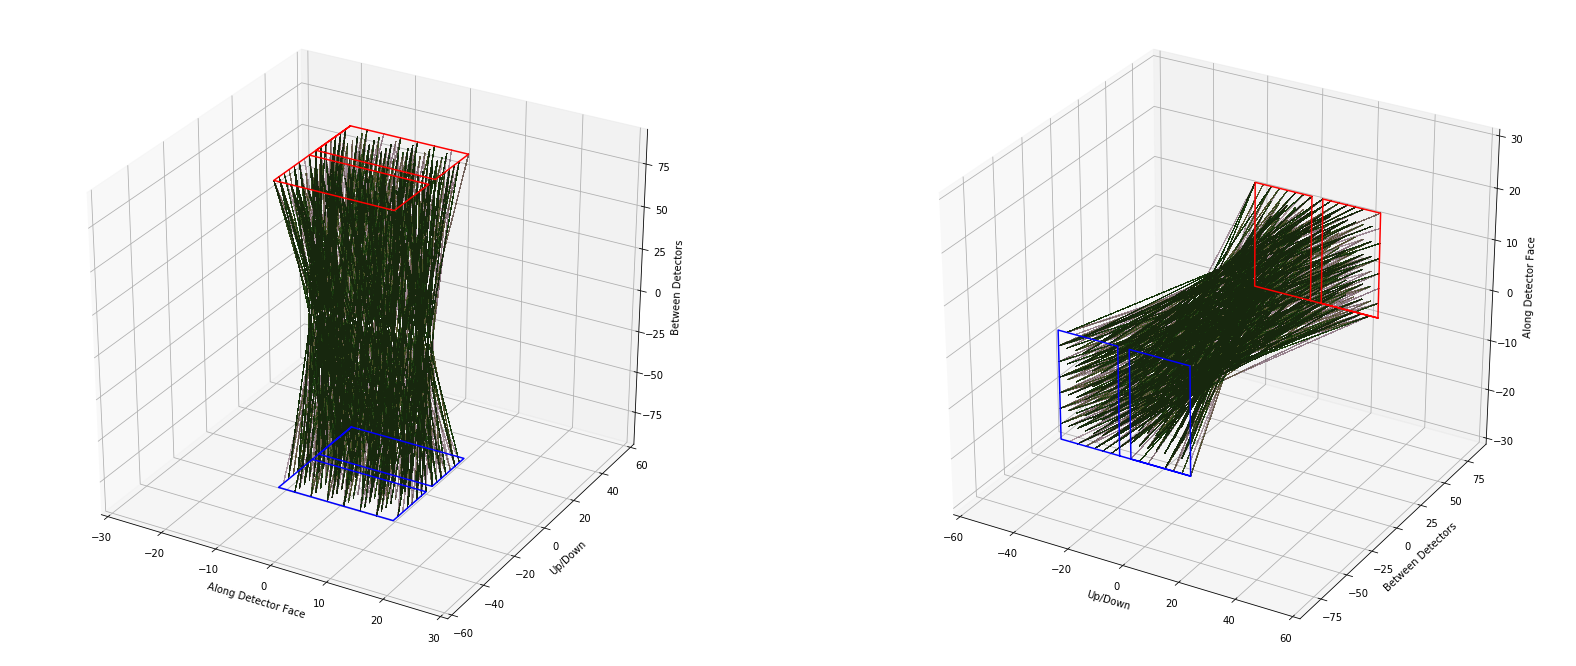

In [74]:
#Basic Backprojection

fig = plt.figure(figsize=(28,12))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax = [ax1,ax2]
nEvt = xyz.shape[1]
for i in range(2):
    #ax[i].scatter(xyz[i%3],xyz[(i+1)%3],xyz[(i+2)%3], c=z,s=16,alpha = 0.2,cmap="nipy_spectral")
    for j in tqdm(range(nEvt)):
        ax[i].plot(xs=[p[i%3,j], p[4+i%3,j]], ys=[p[(i+1)%3,j],p[4+(i+1)%3,j]],zs=[p[(i+2)%3,j],p[4+(i+2)%3,j]], alpha = 0.002)
    
    ax[i].set_xlim(lim[i%3,0],lim[i%3,1])
    ax[i].set_ylim(lim[(i+1)%3,0],lim[(i+1)%3,1])
    ax[i].set_zlim(lim[(i+2)%3,0],lim[(i+2)%3,1])
    ax[i].set_xlabel(labels[i%3])
    ax[i].set_ylabel(labels[(i+1)%3])
    ax[i].set_zlabel(labels[(i+2)%3])
    #ax.scatter([0],[0],[0],c='r',s=6)
    #ax.scatter([0],[-180.25/2],[0],c='g',s=6)
    ax[i].plot(detpoint[i%3],detpoint[(i+1)%3],detpoint[(i+2)%3],c='b')
    ax[i].plot(detpoint2[i%3],detpoint2[(i+1)%3],detpoint2[(i+2)%3],c='r')
fig.savefig(pltdir+"Image_test.png")
plt.show()